In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [3]:
#load dataset
def load_dataset(path):
    return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
    train_idx = np.arange(0,int(len(training)*(100-perc)/100))
    val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
    return train_idx, val_idx


In [23]:
#preparing the data for the LSTM
def prepare_data(df):
    df_raw = df
    #Get pair to evaluate for time series
    #We are going to predict the opening value for each day
    df_raw["Data"] = pd.to_datetime(df_raw["Data"])
    df_raw = df_raw.sort_values("Data")
    df_raw = df_raw.set_index("Data")
    df_raw = df_raw.reindex(columns=['confirmados_arsnorte', 'confirmados_arscentro', 'confirmados_arslvt',
       'confirmados_arsalentejo', 'confirmados_arsalgarve',
       'confirmados_acores', 'confirmados_madeira', 'confirmados_novos',
       'recuperados', 'obitos', 'internados', 'internados_uci',
       'confirmados_0_9_f', 'confirmados_0_9_m', 'confirmados_10_19_f',
       'confirmados_10_19_m', 'confirmados_20_29_f', 'confirmados_20_29_m',
       'confirmados_30_39_f', 'confirmados_30_39_m', 'confirmados_40_49_f',
       'confirmados_40_49_m', 'confirmados_50_59_f', 'confirmados_50_59_m',
       'confirmados_60_69_f', 'confirmados_60_69_m', 'confirmados_70_79_f',
       'confirmados_70_79_m', 'confirmados_80_plus_f', 'confirmados_80_plus_m',
       'obitos_arsnorte', 'obitos_arscentro', 'obitos_arslvt',
       'obitos_arsalentejo', 'obitos_arsalgarve', 'obitos_acores',
       'obitos_madeira', 'obitos_0_9_f', 'obitos_0_9_m', 'obitos_10_19_f',
       'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m', 'obitos_30_39_f',
       'obitos_30_39_m', 'obitos_40_49_f', 'obitos_40_49_m', 'obitos_50_59_f',
       'obitos_50_59_m', 'obitos_60_69_f', 'obitos_60_69_m', 'obitos_70_79_f',
       'obitos_70_79_m', 'obitos_80_plus_f', 'obitos_80_plus_m', 'ativos',
       'internados_enfermaria', 'Max_Temp', 'Min_Temp', 'Temperature',
       'Precipitation', 'Wind_Speed', 'Wind_Direction', 'Visibility',
       'Cloud_Cover', 'Relative_Humidity', 'Rain', 'Clear',
       'Partially_cloudy'])
    # drop de features com correlação alta a outras
    df_raw = df_raw.drop(df_raw.columns.difference(['obitos','confirmados_arsnorte' ,'confirmados_arscentro', 'confirmados_arslvt', 'confirmados_arsalgarve', 'confirmados_acores', 'confirmados_madeira', 'confirmados_novos', 'recuperados', 'internados', 'obitos_arsnorte', 'obitos_arscentro', 'obitos_arsalentejo', 'obitos_80_plus_m', 'Wind_Direction', 'Visibility', 'obitos_0_9_m', 'Cloud_Cover', 'Partially_cloudy']), axis =1)
    # df_raw = df_raw.drop(columns=[ 'obitos_0_9_f', 'obitos_10_19_f', 'obitos_10_19_m', 'obitos_20_29_f', 'obitos_20_29_m',
    #                               'ativos', 'Partially_cloudy', 'commercial_flights'])
    return df_raw


In [6]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    colunas = [x for x in df.columns if x != 'obitos']
    print(colunas)
    for col in colunas:
        df[[col]] = scaler.fit_transform(df[[col]])
    df[['obitos']] = scaler.fit_transform(df[['obitos']])
    
    return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
    #accuracies and losses
    #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    epochs_range = range(epochs)
    #creating figure
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,2)
    plt.plot(epochs_range,loss,label='Training Loss')
    plt.plot(epochs_range,val_loss,label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss')
    plt.show()


In [8]:
#Plot time series data
def plot_confirmed_cases(data):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)), data)
    plt.title('Dataset Features')
    plt.ylabel('Valores')
    plt.xlabel('Semanas')
    plt.show()

In [9]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
    data = df.values
    X,y = list(), list()
    #iterate over the training set to create X and y
    dataset_size = len(data)
    for curr_pos in range(dataset_size):
        #end of the input sequence is the current position + the number of the timesteps of the input sequence
        input_index = curr_pos + timesteps
        #end of the labels corresponds to the end of the input sequence + 1
        label_index = input_index + 1
        #if we have enough data for this sequence
        if label_index < dataset_size:
            X.append(data[curr_pos:input_index,:])
            y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
    return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, filters= 16, kernel_size=5, pool_size =2 ):
    #using the functional API
    inputs = tf.keras.layers.Input(shape=(timesteps, features))
    #microarchitecture
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
    x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
    #last layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(filters)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    #the model
    cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
    tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
    return cnnModel

In [12]:
def compile_and_fit(model, epochs, batch_size):
    #compile
    model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae',rmse])
    #fit
    hist_list = list()
    loss_list = list()
    #Time Series Cross Validator
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    for train_index, test_index in tscv.split(X):
        train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
        #build data
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        X_test, y_test = X[test_index], y[test_index]
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
        metrics = model.evaluate(X_test, y_test)

        plot_learning_curves(history, epochs)
        hist_list.append(history)

    return model, hist_list

In [13]:
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = df[-timesteps:].values #getting the last sequence of known value
    inp = input_seq
    forecasts = list()
    print(inp)
    #multistep tells us how many iterations we want to perform
    #i. e. how many days we want to predict
    for step in range(1, multisteps+1):
        #implement
        inp = inp.reshape(1, timesteps, n_variate)
        pred = model.predict(inp)
        yhat_inversed = scaler.inverse_transform(pred)
        forecasts.append(yhat_inversed)
        #prepare new input to forecast the next day
        # inp = np.append(inp[0], pred)        
        # inp = inp[-timesteps:]
        # list_pred = [pred[0][i] for i in range(len(pred[0]))]
        # print('list_yhat:')
        # print(list_pred)
        # inp= np.append(inp[0],[list_pred],axis=0) #adiciona previsão recente ao input
        # inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
        # print(step)
        print(step)
            
    return forecasts

In [14]:
def plot_forecast(data, forecasts):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)),data["obitos"], color='green', label='Confirmed')
        
    fi=[]
    for f in forecasts:
        fi.append(f[0][0])
        print('Previsão:' + str(f))
    print(fi)
        
    plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
    plt.title('Mortes por covid')
    plt.ylabel('Mortes')
    plt.xlabel('Meses')
    plt.legend()
    plt.show()

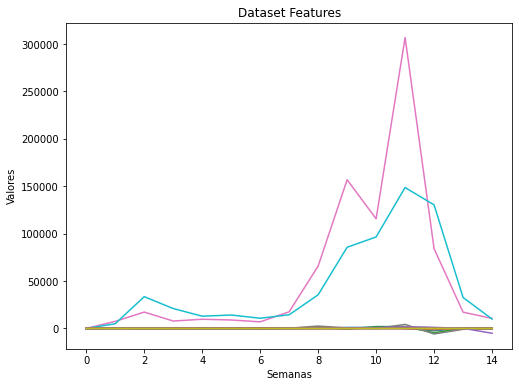

['confirmados_arsnorte', 'confirmados_arscentro', 'confirmados_arslvt', 'confirmados_arsalgarve', 'confirmados_acores', 'confirmados_madeira', 'confirmados_novos', 'recuperados', 'internados', 'obitos_arsnorte', 'obitos_arscentro', 'obitos_arsalentejo', 'obitos_0_9_m', 'obitos_80_plus_m', 'Wind_Direction', 'Visibility', 'Cloud_Cover', 'Partially_cloudy']
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.4821 - mae: 0.4814 - rmse: 0.4821
Epoch 2/10
1/1 [==============================] - 0s 53ms/step - loss: 0.4321 - mae: 0.4313 - rmse: 0.4321
Epoch 3/10
1/1 [==============================] - 0s 58ms/step - loss: 0.3825 - mae: 0.3815 - rmse: 0.3825
Epoch 4/10
1/1 [==============================] - 0s 50ms/step - loss: 0.3329 - mae: 0.3318 - rmse: 0.3329
Epoch 5/10
1/1 [==============================] - 0s 55ms/step - loss

KeyError: 'val_loss'

In [24]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('data_covid.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 5, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 }#,
                  #2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  #3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  #
                  #4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  #5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  #6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  #
                  #7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  #8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  #9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
    # print(record[r])
    # fitting the model
    timesteps = tunning_dict[t]['timesteps']
    epochs = tunning_dict[t]['epochs']
    batch_size = tunning_dict[t]['batch_size']
    multisteps = tunning_dict[t]['multisteps']
    cv_splits = tunning_dict[t]['cv_splits']
    # print(timesteps,epochs,batch_size,cv_splits)

    X, y = to_supervised(df, timesteps)

    model = build_model(timesteps, n_variate)
    model, history = compile_and_fit(model, epochs, batch_size)
    # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
    forecasts = forecast(model, df, timesteps, multisteps, scaler)
    plot_forecast(df_data, forecasts)
    print(forecasts)

    prev = []

    record[t] = history


#Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
        # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
        # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
        # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
        # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
        loss.append(sum(h.history['loss']) / len(h.history['loss']))
        mae.append(sum(h.history['mae']) / len(h.history['mae']))
        rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
        val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
        val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
        val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
        id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1

In [ ]:
for f in final_dict:
print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.10086262313028177, 0.0875071513156096, 0.09776540212333203, 0.1426882608483235, 0.12633008857568107, 0.1426882608483235] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.100863,0.087507,0.097765,0.142688,0.12633,0.142688


In [ ]:
#Results metrics to a file
final_df.to_csv(r"resultados_cnn_covid.csv",index=True)